In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix

from data import load_simple_data
from model import load_net

/home/igui/.pyenv/versions/3.8.16/envs/SEM-MacridVAE/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = 'amazon-home'

In [4]:
info = f'{dataset}-DisenEVAE-50E-100B-0.001L-0.0001W-0.5D-0.2b-7k-200d-0.1t-98765s'

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
# Parameters
model='DisenEVAE'
seed=98765
lr=1e-3
weight_decay=1e-4
dropout=0.5
beta=0.2
kfac=7
dfac=200
tau=0.1
data_dir=dataset
batch_size=100

In [8]:
dir = Path('RecomData') / data_dir / 'prep'
print('Loading data')

data = load_simple_data(dir)
train = data.train

Loading data


In [10]:
print('Loading model')
net = load_net(model=model, 
               N=data.n_users, 
               M=data.n_items,
               K=kfac, D=dfac,
               tau=tau, dropout=dropout, 
               items=data.items_embed, 
               items_textual=data.text_embed, 
               items_visual=data.image_embed
               )
net = net.to(device)

Loading model


In [11]:
net.eval()
n_visual = train.shape[0]
n_items = train.shape[1]

users = []
with torch.no_grad():
    for start_idx in range(0, n_visual, batch_size):
        X = train[start_idx:start_idx + batch_size]
        X = torch.Tensor(X.toarray()).to(device)
        _, X_mu, _, _, _, _ = net(X, A=None)
        users.append(X_mu)

users = torch.cat(users).detach().cpu()
items = net.state_dict()['items'].detach().cpu()
cores = net.state_dict()['cores'].detach().cpu()

users = F.normalize(users).view(-1, kfac, dfac)
items = F.normalize(items)
cores = F.normalize(cores)


In [12]:
items.shape

torch.Size([29040, 200])

Alignment of item and categories

In [13]:
item_cate = np.argmax(items @ cores.T, axis=1).numpy()

pd.Series(item_cate).value_counts()

6    5293
3    4676
1    4675
0    4191
4    3651
5    3438
2    3116
dtype: int64

In [14]:
def get_users_in_category(users, item_cate):
    item_cate_sparse = np.zeros((n_items, kfac), dtype=np.int64)
    item_cate_sparse[np.arange(n_items), item_cate] = 1
    users_user, users_cate = train.dot(item_cate_sparse).nonzero()
    return users[users_user, users_cate, :], users_cate

users_in_category, users_cate = get_users_in_category(users, item_cate)
print(users_in_category.shape)
print(users_cate.shape)

torch.Size([40065, 200])
(40065,)


In [12]:
all_nodes = torch.cat([items, users_in_category], dim=0).numpy()
all_nodes.shape

(69299, 200)

In [13]:
all_nodes_embedded = TSNE(n_components=2, verbose=True, n_jobs=8).fit_transform(all_nodes)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 69299 samples in 0.004s...
[t-SNE] Computed neighbors for 69299 samples in 13.131s...
[t-SNE] Computed conditional probabilities for sample 1000 / 69299
[t-SNE] Computed conditional probabilities for sample 2000 / 69299
[t-SNE] Computed conditional probabilities for sample 3000 / 69299
[t-SNE] Computed conditional probabilities for sample 4000 / 69299
[t-SNE] Computed conditional probabilities for sample 5000 / 69299
[t-SNE] Computed conditional probabilities for sample 6000 / 69299
[t-SNE] Computed conditional probabilities for sample 7000 / 69299
[t-SNE] Computed conditional probabilities for sample 8000 / 69299
[t-SNE] Computed conditional probabilities for sample 9000 / 69299
[t-SNE] Computed conditional probabilities for sample 10000 / 69299
[t-SNE] Computed conditional probabilities for sample 11000 / 69299
[t-SNE] Computed conditional probabilities for sample 12000 / 69299
[t-SNE] Computed conditional probabilities for sa

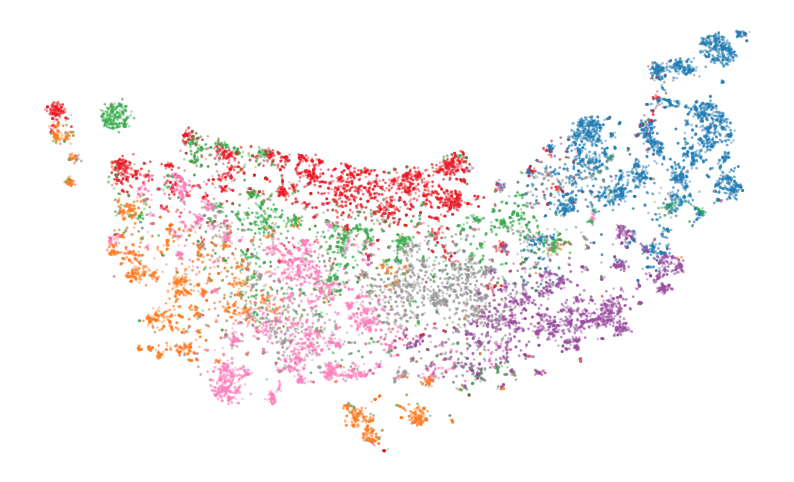

In [151]:
def plot_all_items(items_embedded, item_cate):
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot()
        ax.set_axis_off()
        ax.scatter(items_embedded[:, 0], items_embedded[:, 1], c=palette[item_cate], s=1)
        plt.show()

plot_all_items(all_nodes_embedded[:n_items], item_cate)
# plot_all_items(all_nodes_embedded[n_items:], users_cate)
#plot_all_items(all_nodes_embedded, np.concatenate([item_cate, users_cate]))


Plot items only

In [19]:
items_embedded = TSNE(n_components=2, verbose=True, n_jobs=8).fit_transform(items)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38493 samples in 0.004s...
[t-SNE] Computed neighbors for 38493 samples in 4.535s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38493
[t-SNE] Computed conditional probabilities for sample 2000 / 38493
[t-SNE] Computed conditional probabilities for sample 3000 / 38493
[t-SNE] Computed conditional probabilities for sample 4000 / 38493
[t-SNE] Computed conditional probabilities for sample 5000 / 38493
[t-SNE] Computed conditional probabilities for sample 6000 / 38493
[t-SNE] Computed conditional probabilities for sample 7000 / 38493
[t-SNE] Computed conditional probabilities for sample 8000 / 38493
[t-SNE] Computed conditional probabilities for sample 9000 / 38493
[t-SNE] Computed conditional probabilities for sample 10000 / 38493
[t-SNE] Computed conditional probabilities for sample 11000 / 38493
[t-SNE] Computed conditional probabilities for sample 12000 / 38493
[t-SNE] Computed conditional probabilities for sam

ValueError: 'c' argument has 29040 elements, which is inconsistent with 'x' and 'y' with size 38493.

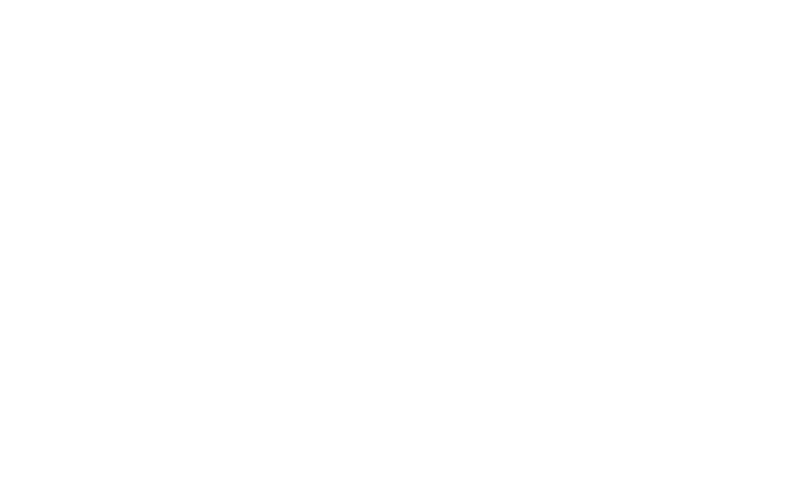

In [156]:
palette = np.array(
        [[35 , 126, 181, 80], # _0. Blue
        [255, 129, 190, 80],  # _1. Pink
        [255, 127, 38 , 80],  # _2. Orange
        [59 , 175, 81 , 80],  # _3. Green
        [156, 78 , 161, 80],  # _4. Purple
        [238, 27 , 39 , 80],  # _5. Red
        [153, 153, 153, 80]], # _6. Gray
        dtype=float) / 255.0

def plot_all_items(items_embedded, item_cate):
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot()
        ax.set_axis_off()
        ax.scatter(items_embedded[:, 0], items_embedded[:, 1], c=palette[item_cate], s=1)
        plt.show()

plot_all_items(items_embedded, item_cate)

Image for 17363 not found
Image for 18872 not found
Image for 17524 not found


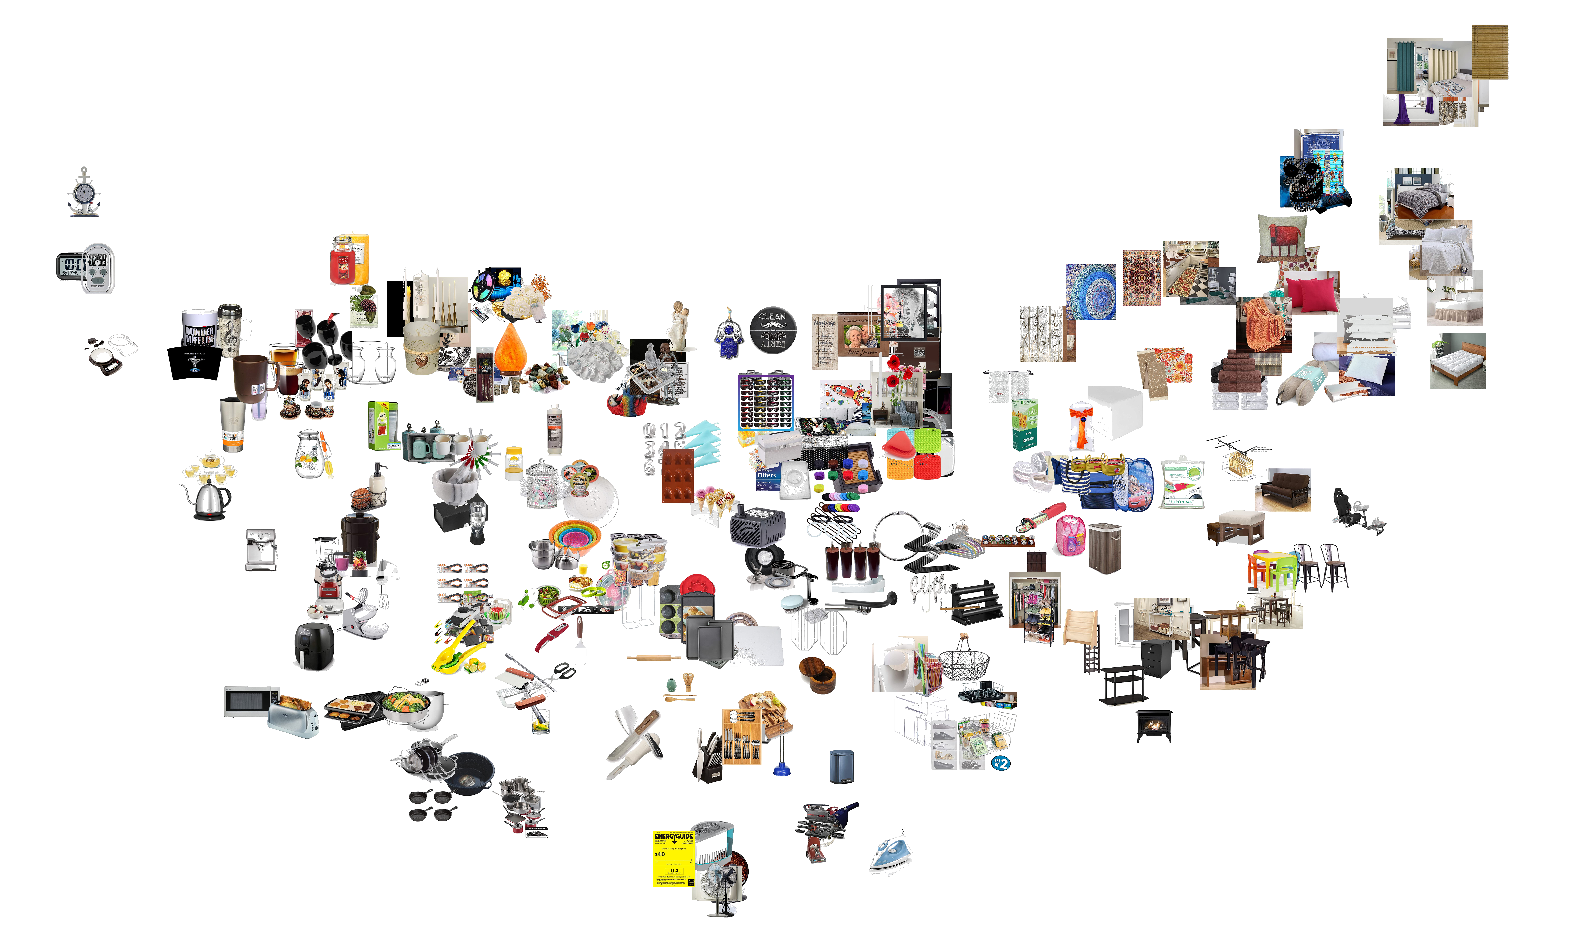

In [155]:
def plot_some_items_images(items_embedded, n: int):
    sample = np.random.choice(n_items, n, replace=False)
    #sample = np.arange(n)

    fig = plt.figure(figsize=(20, 12))
    ax = fig.add_subplot()
    ax.set_axis_off()

    ax.scatter(
        items_embedded[sample, 0],
        items_embedded[sample, 1], 
        alpha=0.0,
        c=palette[item_cate[sample]]
    )
    
    for x in sample:
        image_path = dir / f'images/{x}.png'
        if not image_path.exists():
            print(f'Image for {x} not found')
            continue
        img = OffsetImage(plt.imread(str(image_path)), zoom=0.1)
        ab = AnnotationBbox(img, (items_embedded[x, 0], items_embedded[x, 1]), frameon=False)
        ax.add_artist(ab)

    plt.show()

plot_some_items_images(all_nodes_embedded[:n_items], 300)

